# 0. Data Download

In [2]:
!pip install torchaudio
import torch
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

SR = 16000
eps = 1e-6 # epsilon
DEV = 'cpu' # device
torch.set_printoptions(sci_mode=False) # 소수점 출력을 제한

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!git clone https://github.com/clayryu/GTZAN-Dataset---Music-Genre-Classification.git

%cd GTZAN-Dataset---Music-Genre-Classification
%cd GTZAN_Dataset_Music_Genre_Classification
%cd Data

Cloning into 'GTZAN-Dataset---Music-Genre-Classification'...
remote: Enumerating objects: 2002, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2002 (delta 0), reused 3 (delta 0), pack-reused 1999
Receiving objects: 100% (2002/2002), 1.19 GiB | 13.96 MiB/s, done.
Checking out files: 100% (2002/2002), done.
/content/GTZAN-Dataset---Music-Genre-Classification
/content/GTZAN-Dataset---Music-Genre-Classification/GTZAN_Dataset_Music_Genre_Classification
/content/GTZAN-Dataset---Music-Genre-Classification/GTZAN_Dataset_Music_Genre_Classification/Data


In [17]:
from pathlib import Path
dir_path = Path('genres_original/')
fp_list = list(dir_path.rglob("*.wav"))
len(fp_list) #1000개의 data가 들어왔음을 확인할 수 있다.

1000

In [26]:
fp = fp_list[500]
y, sr = torchaudio.load(fp)
ipd.Audio(y, rate= sr) #0번째 샘플의 오디오를 들어보기 -> rock/68번째 샘플

In [22]:
y.shape, sr # [mono, audio sample ], [Sampling Rate]

(torch.Size([1, 661794]), 22050)

# Resample to 16000HZ

In [36]:
resampler = torchaudio.transforms.Resample(orig_freq = 22050, new_freq = SR)
y_ds = resampler(y)
ipd.Audio(y_ds, rate = SR), y_ds.shape

(<IPython.lib.display.Audio object>, torch.Size([1, 480214]))

In [33]:
spec_conveter = torchaudio.transforms.Spectrogram(n_fft = 1024)
db_conveter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_conveter(spec_conveter(y))
db_spec.shape

torch.Size([1, 513, 1293])

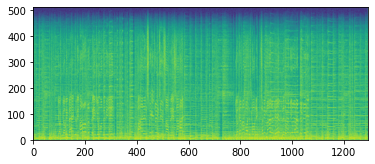

In [31]:
plt.imshow(db_spec[0], origin = 'lower')

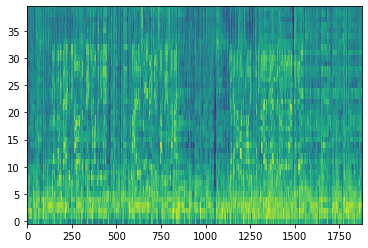

In [46]:
# mel_spectrogram 만들기
mel_spec_conveter = torchaudio.transforms.MelSpectrogram(sample_rate = SR, n_fft = 512, n_mels =40, f_max=6000)
mel_spec = mel_spec_conveter(y_ds)
plt.imshow(db_conveter(mel_spec[0]), origin = 'lower', aspect = 'auto', interpolation = 'nearest')

In [ ]:
# Genre index 매기기


In [145]:
class GTZANDataset:
  def __init__(self, dir_path, split ='train'):
    self.dir_path = Path(dir_path)
    self.wave_ps = list(self.dir_path.rglob("*.wav")) #genrator -> list
    self.wave_pths = []
    #batch 를 지정해서 만들다가, jazz.00054 파일에 에러가 떴다. 그래서 00054는 예외처리를 해주었다.
    for i in self.wave_ps:
      if i.stem == 'jazz.00054':
        pass
      else:
        self.wave_pths.append(i)

  
    splitted_pths = []
    for pth in self.wave_pths:
      if split =='train' and int(pth.stem.split('.')[1])<60:
          splitted_pths.append(pth)
      elif split =='valid' and 60<= int(pth.stem.split('.')[1])<80:
          splitted_pths.append(pth)
      elif split =='test' and int(pth.stem.split('.')[1])>=80:
          splitted_pths.append(pth)
    self.wave_pths = splitted_pths

    # Genre indexing
    self.genre_names = list(set([x.stem.split('.')[0] for x in self.wave_pths]))
    self.genre_names.sort()
    self.str2idx = {string:idx for idx, string in enumerate (self.genre_names)}
  def __len__(self):
      return len(self.wave_pths)

  def __getitem__(self, idx): #idx -> input parameter
    pth = self.wave_pths[idx]
    audio_sample, sr = torchaudio.load(pth)
    genre_str = pth.stem.split('.')[0]
    #29초로 모두 동일화

    return audio_sample[0,:sr*29], self.str2idx[genre_str]

trainset = GTZANDataset('genres_original/')
validset = GTZANDataset('genres_original/', split= 'valid')
testset = GTZANDataset('genres_original/', split= 'test')
print(len(trainset), len(validset), len(testset))
print(trainset[0])



599 200 200
(tensor([ 0.0031,  0.0014,  0.0042,  ..., -0.0096, -0.0067, -0.0039]), 1)


In [119]:
#dataset.wave_pths[0].stem, dataset.wave_pths[0].stem.split('.')[1] 

('classical.00095', '00095')

In [153]:
# make batch test
from torch.utils.data import DataLoader

dataloader = DataLoader(trainset, batch_size=16, shuffle=True)
dataloader

In [154]:
for batch in dataloader:
  audio, label = batch 
  print(label)
  print(batch)
  break
# why error? 모든 샘플의 행렬의 크기가 동일하지 않음
# 어떤건 30.1초, 30.2초 등등, 즉 오디오 샘플 size가 다르기 때문임

tensor([6, 6, 0, 3, 5, 0, 0, 6, 4, 9, 1, 1, 7, 4, 5, 9])
[tensor([[ 0.4111,  0.4339,  0.3624,  ...,  0.1208,  0.1233,  0.0884],
        [-0.1912, -0.2327, -0.1391,  ..., -0.1056, -0.1686, -0.2199],
        [-0.1417, -0.2229, -0.1965,  ..., -0.0856, -0.1638, -0.2524],
        ...,
        [-0.2561, -0.2187, -0.1582,  ..., -0.1501, -0.0961, -0.0858],
        [ 0.0215,  0.0427,  0.0417,  ...,  0.0070, -0.0204, -0.0428],
        [-0.1164, -0.1278, -0.1231,  ...,  0.0330,  0.0453,  0.1181]]), tensor([6, 6, 0, 3, 5, 0, 0, 6, 4, 9, 1, 1, 7, 4, 5, 9])]


In [142]:
print(trainset.genre_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


- Make Train Loop


# DATA 로드
- 1. 미리 오디오를 다 읽어온다 (Ram에 저장) 
- -> ram 사이즈가 많이 필요

- 2. 매번 필요할때마다 불러온다
- hdd면 느리며, 큰 파일이면 느림

- 3. 적당한 파일로 미리 저장해둔다.
- resampling / Mel Spectrogram

In [157]:
import torch.nn as nn
import torch
class GenreModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.num_frame = 30
    self.n_mels = 40
    
    self.mel_spec_converter = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=1024, n_mels=self.n_mels, f_max=6000)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()

    
    self.nn_layer = nn.Sequential(
                    nn.Linear(self.n_mels*self.num_frame, 128), # input layer. take input and return hidden representation
                    nn.ReLU(),
                    nn.Linear(128, 64), # hidden layer. 
                    nn.ReLU(),
                    nn.Linear(64, 10),  # output layer 
    )
    
  def forward(self, x):
    spec = self.mel_spec_converter(x)
    db_spec = self.db_converter(spec)
#     print(db_spec.shape)
    sliced_spec = db_spec[:,:,db_spec.shape[2]//2:db_spec.shape[2]//2+self.num_frame]
#     print('before flattening', sliced_spec.shape)
    sliced_spec = sliced_spec.reshape(x.shape[0], -1) # -1은 남는 디멘션을 자동으로 계산. 전체 element가 3200이고 0번째 dim 8이면 남은 1번째 디멘션은 자동으로 400
#     print('after flattening', sliced_spec.shape)

    out = self.nn_layer(sliced_spec)
    
    return torch.softmax(out, dim=-1)
  
# model = GenreModel()
audio, label = batch
model = GenreModel()
out = model(audio) 
out[:4], label[:4]
# 위에서 for문을 돌렸기 때문에 현재는 마지막 batch인 [7, 639450] 의 Matrix가 들어간 것임.
# model(batch) => GenereModel.forward(batch) nn.module을 불러서 변수를 넣으면 바로 forward문으로 바뀜

(tensor([[0.0334, 0.0567, 0.6316, 0.1100, 0.0398, 0.0160, 0.0214, 0.0225, 0.0326,
          0.0360],
         [0.0398, 0.1045, 0.2235, 0.2432, 0.0502, 0.0590, 0.0231, 0.0337, 0.1993,
          0.0239],
         [0.0527, 0.1456, 0.4360, 0.1058, 0.0713, 0.0844, 0.0122, 0.0334, 0.0417,
          0.0169],
         [0.0168, 0.1494, 0.5345, 0.0887, 0.0363, 0.0351, 0.0384, 0.0316, 0.0315,
          0.0376]], grad_fn=<SliceBackward0>), tensor([6, 6, 0, 3]))

In [109]:
test = torch.arange(48)
test1 = torch.arange(48).reshape(6,8)
test2 = torch.arange(48).view(6, 8)

test.shape, test1.shape, test2.shape

(torch.Size([48]), torch.Size([6, 8]), torch.Size([6, 8]))

In [117]:
'''
10개의 time bin을 볼때, 여기에 포함된 전체 샘플 수 

1번째 샘플의 갯수 : 512
2번째 까지의 샘플의 갯수 : 512 + 256
3번째 : 512 + 256 + 256
'''

hop_size =256
n_fft = 512

num_total_samples = 512 + (10-1) * 256
time = num_total_samples / 22050
time
#우리는 0.12초 정도를 사용함을 알 수 있다.

0.12770975056689343

In [162]:
# 모듈이 있지만 , nll 수동으로 짜보기
def get_nll(pred, target, eps = 1e-6):
  pred_value_for_correct_class = pred[torch.arange(len(target)), target]
  nll_value = -torch.log(pred_value_for_correct_class + eps)
  return torch.mean(nll_value)
get_nll(out, label)

tensor(2.8214, grad_fn=<MeanBackward0>)

In [193]:
def validate_model(model, data_loader):
  val_loss = 0
  val_acc = 0 
  with torch.no_grad():
    for batch in data_loader:
      audio, label = batch
      prediction = model(audio)
      loss = get_nll(prediction, label)
      val_loss += loss.item() * len(label)
      
      val_acc += (torch.argmax(prediction, dim=-1) == label).sum().float().item() 
      
  val_loss /=  len(data_loader.dataset)
  val_acc /= len(data_loader.dataset)
  return val_loss, val_acc

In [178]:
train_loader = DataLoader(trainset, batch_size = 32, shuffle= True)
valid_loader = DataLoader(trainset, batch_size = 128, shuffle= False)
test_loader = DataLoader(trainset, batch_size = 128, shuffle= False)

In [196]:
model = GenreModel()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

loss_record = []
val_loss_record = []
val_acc_record = []
num_epchocs = 5
for epcch in range(num_epchocs):
  for batch in train_loader:
    audio, label = batch # x = audio / y = label
    prediction= model(audio)
    loss= get_nll(prediction, label)
    loss.backward() #backpro and caclulate gradient
    optimizer.step()
    optimizer.zero_grad() 
    loss_record.append(loss.item())
  val_loss, val_acc = validate_model(model, valid_loader)
  val_loss_record.append(val_loss)
  val_acc_record.append(val_acc)

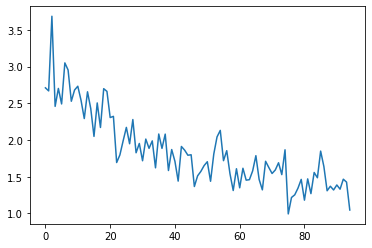

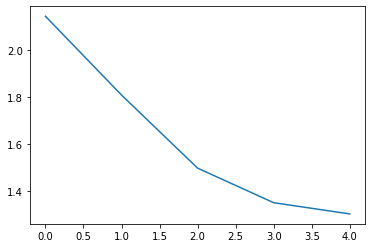

In [200]:
plt.figure(1)
plt.plot(loss_record)
plt.figure(2)
plt.plot(val_loss_record)
